# Introduction

Spam email isn't just annoying, it's also harmful. Spam emails, the term for unwanted emails that have been innudating inboxes for almost a long as email has been around and contain unsolicited ads, messages, or even malware. Not only do these barrage of unwanted emails clog up inboxes and create inefficiency, they also pose a risk to individual's and businesses' private data. In fact, in 2020, Deloitte reported that 91% of all cyber attacks begin as a phishing email. 

With this level of threat, it's easy to understand why significant effort has been put toward preventing spam emails from ever reaching users. Given the dynamic nature of spam emails, machine learning has been one of the best tools in addressing the issue of spam. While a number of spam detection systems are deployed within email providers such as Outlook and Gmail, an attempt to recreate a spam detection method will be conducted.

The general approach will be to see if the contents of the email message body, paired with a machine learning classification algorithm can be utilized to correctly determine if a message is spam. The email data was sourced from https://spamassassin.apache.org/, an open source antispam filter project. A number of machine learning models were sourced from the sklearn library using Python. Additionally, a number of the data cleaning approaches were originally sourced from *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* and slightly modified to expand upon the book examples. Ultimately, the best performing model was an optimized logistic regression model that returned an accuracy score of 95%, a precision of 32%, and a recall of 28%. It was also concluded that the training data set size should be expanded and additional features of the email should be incorporated into the training data other than just the message body. 

# Problem Statement

Spam emails often have a variety of factors that may indicate the fact that it is spam. While many follow a specific pattern, coding a set of rule based checks to determine spam would be quite labor intensive and likely still yield poor results since the ability to manually identify all needed instances of a spam email is not realistic. As a result machine, learning approaches are applied due to the dynamic nature of the algorithms and the ability for the models to be continously trained with new data if needed. 

The machine learning approaches must be classification based, since the output is binary in nature, either it is spam, or it is not. The three classification machine learning algorithms evaluated were logistic regression, random forest classifier, and k nearest neighbors. The general workflow for this project is as follows:
1. Import, explore, and process the email data set. 
2. Evaluate the different classification algorithms
3. Determine the best performing classification algorithm
4. Test the best performing model and record results
5. Discuss any future investigations or improvements 

The first model evaluated is logistic regression. Logistic regression is a classification algorithm where a s-curve function from 0 to 1 is fitted to the data based upon the maximum likelyhood, which is the measurement of how much the model correctly describes the outcomes based upon the observed data. An illustration of logistic regression is below.

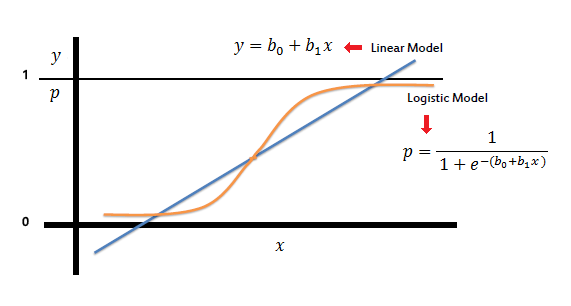

The second model evaluated was the random forest classifier. The random forest classification model is a ensemble method of the decision tree classification model. This combination of multiple decision trees, each trained on a subset of data, often leads to less overfitting on the training set by the model than compared to the single decision tree method. The predictions of each tree are averaged together giving the model a more generalized approach than a single decision tree. An illustration of a random forest model is shown below.

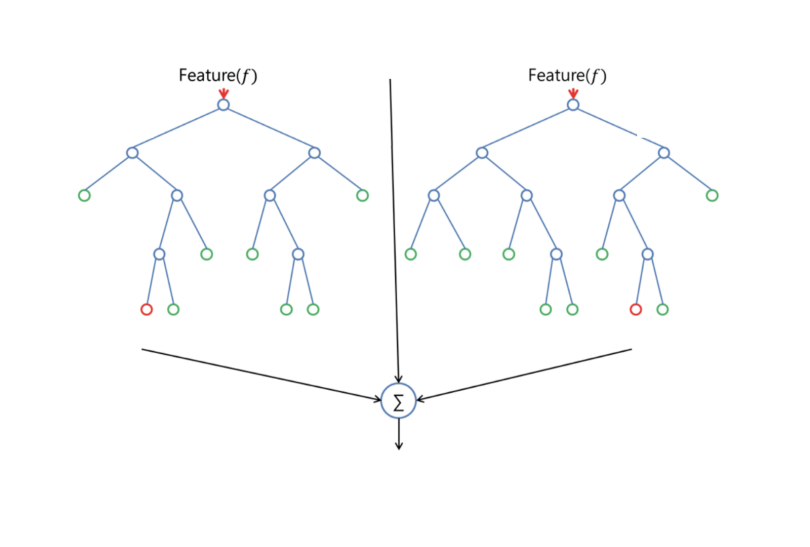

The third and final model evaluated was the k nearest neighbors, which uses the proximity of a data point to other data points to determine the specific classification of that point. An illustration of k nearest neighbors is shown below. 

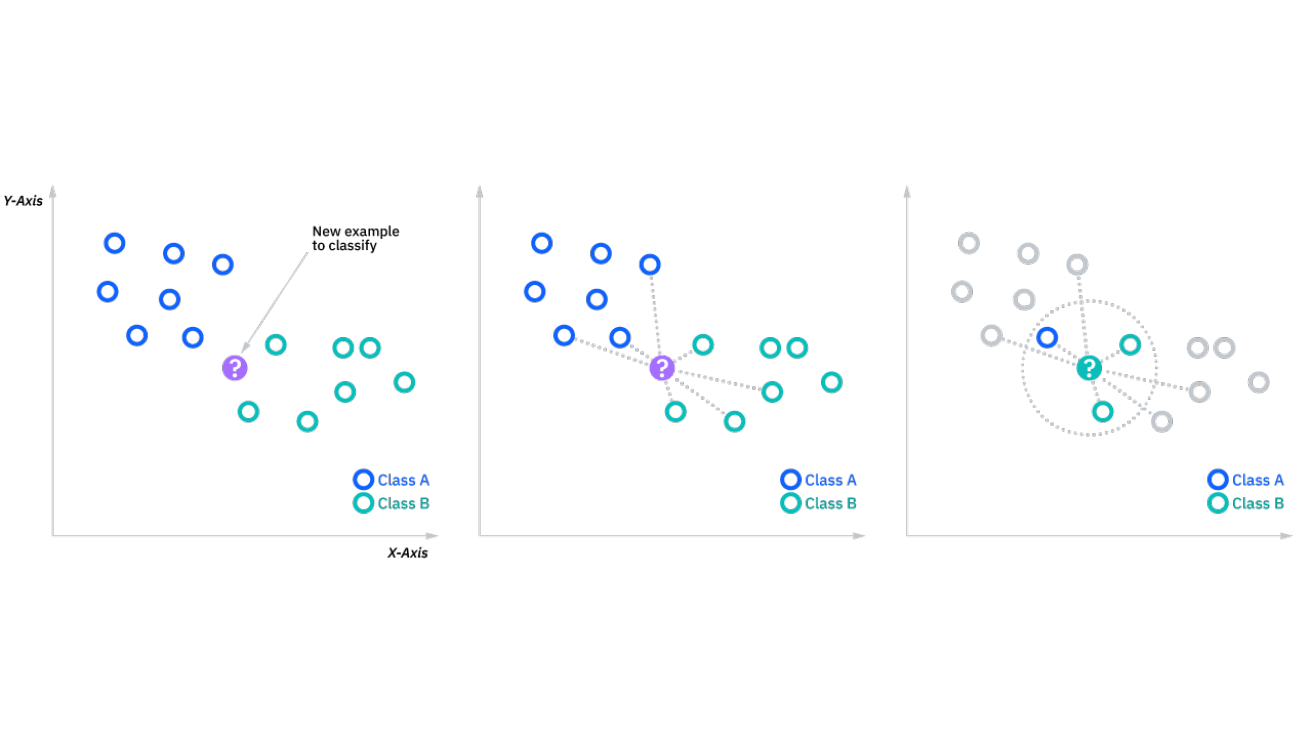

# Experimental Evaluation 

Since this is a classification problem, a number of methods will be used to determine the best performing model. Accuracy, precision, and recall will be the specific metrics used to describe model performance, and the confusion matrix for each model will be evaluated to give additional context to the metrics. Accuracy is the total number of correct predictions over the total number of predictions. However, this metric needs to be understood in the greater context of how many false positives and how many false negatives were observed? This is where precision and recall are utilized. Precision describes how often a model incorrectly classified something as positive, or in this case spam. While recall describes how often a model incorrectly classified something as negative, or in this case not spam. The equations for precision and recall are shown below.

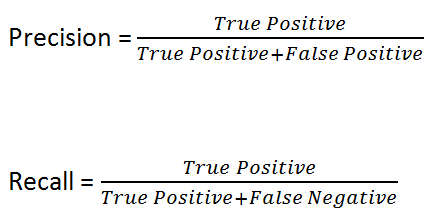

There is often a trade off between precision and recall, as one increases the other can decrease. If this is the case, the focus for the model evaluation is on precision. This stems from the risk that cyber attacks via spam email provide. It's the opinion of the author that due to this cyber risk, catching as much spam as possible at the loss of non spam is preferable. However, advertisers, sales teams, and password reset developers may feel differently, so a model with both high precision and high recall will be selected if available. 

The inputs for this problem come from the emails collected and labeled by Spam Assassin in the early to mid 2000s. This data source is a reasonable basis since the Spam Assassin project is apart of the Apache Foundation, one of the premier collection of open source projects. The only drawback to this data is the age of it. If this were to be an actual commercialized data model, then the source of data would benefit from additional data points after 2005. 

While there is a significant amount of information incased into each email, the focus is on the message text of the email. Therefore the inputs for the model are vectors that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1].

The output is a binary classification for if the email is spam or not. 

# Data Pre-Processing 

The input data for this project required a number of transformations to prepare it for processing in the machine learning model. The data required the following steps to be conducted:

1. Read in and extract the files from Spam Assassin.
2. Split the data into training, validation, and test sets.
3. Clean the text to make it more uniform
4. Remove URLs and stem the text
5. Convert the text into word count vectors. 



In [130]:
import pandas as pd 
import tarfile as tf 
from pathlib import Path
import urllib.request
import urlextract
import nltk
import copy

The data is read into the notebook and extracted from the tar files. 

In [131]:
import tarfile
  
def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url_one = spam_root + "20021010_easy_ham.tar.bz2"
    spam_url_one = spam_root + "20021010_spam.tar.bz2"
    ham_url_two = spam_root + "20021010_hard_ham.tar.bz2"
    spam_url_two = spam_root + '20030228_spam.tar.bz2'
    ham_url_three = spam_root + '20030228_easy_ham.tar.bz2'
    spam_url_three = spam_root + '20030228_spam_2.tar.bz2'
    ham_url_four = spam_root + '20030228_hard_ham.tar.bz2'
    spam_url_four = spam_root + '20050311_spam_2.tar.bz2'
    
    
    
    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url_one),
                                    ("spam", "spam", spam_url_one),
                                    ("hard_ham", "ham", ham_url_two),
                                    ("spam", "spam", spam_url_two),
                                    ("easy_ham", "ham", ham_url_three),
                                    ("spam", "spam", spam_url_three),
                                    ("hard_ham", "ham", ham_url_four),
                                    ("spam", "spam", spam_url_four)):
        if not (spam_path / dir_name).is_dir():

            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()

    return [spam_path / dir_name for dir_name in ("easy_ham", "hard_ham", "spam")]



In [132]:
easy_ham_dir, hard_ham_dir, spam_dir = fetch_spam_data()

In [133]:
easy_ham_filenames = [f for f in sorted(easy_ham_dir.iterdir()) if len(f.name) > 20]
hard_ham_filenames = [f for f in sorted(hard_ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [134]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

Using the email libary, the structure of the email is determined. Keep in mind, there is a lot of potentially useful information here, but the focus is on the message content. Additionally, the data will be split in a test, train, and validation set to allow the different models to be evaluated on the validation set and the final model will be evaluated based upon the test set. 

In [135]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [136]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [137]:
easy_ham_emails = [load_email(filepath) for filepath in easy_ham_filenames]
hard_ham_emails = [load_email(filepath) for filepath in hard_ham_filenames]
ham_emails = copy.deepcopy(easy_ham_emails)
ham_emails.extend(hard_ham_emails)
spam_emails = [load_email(filepath) for filepath in spam_filenames]

In [138]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train_org, X_test, y_train_org, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X_train_org, y_train_org, test_size = 0.2,
                                                     random_state = 42)

In [139]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [140]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [141]:
url_extractor = urlextract.URLExtract()

stemmer = nltk.PorterStemmer()

In [142]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

After the data is fully transformed, the output is indeed a word vector. 

In [143]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'your': 11, 'number': 10, 'and': 7, 'for': 5, 'you': 5, 'to': 5, 'thi': 4, 'hyperlink': 4, 'comput': 3, 'from': 3, 'inform': 3, 'click': 3, 'here': 3, 'in': 3, 'list': 3, 'a': 2, 'all': 2, 'special': 2, 'softwar': 2, 'includ': 2, 'featur': 2, 'pack': 2, 'price': 2, 'protect': 2, 'virus': 2, 'valuabl': 2, 'send': 2, 'or': 2, 'email': 2, 'opt': 2, 'if': 2, 'be': 2, 'unsubscrib': 2, 'spam': 2, 'attent': 1, 'is': 1, 'must': 1, 'user': 1, 'new': 1, 'packag': 1, 'deal': 1, 'norton': 1, 'systemwork': 1, 'suit': 1, 'profession': 1, 'edit': 1, 'six': 1, 'ye': 1, 'utilitiesal': 1, 'low': 1, 'will': 1, 'unwant': 1, 'hazard': 1, 'help': 1, 'secur': 1, 'privat': 1, 'allow': 1, 'transfer': 1, 'file': 1, 'e': 1, 'mail': 1, 'safe': 1, 'backup': 1, 'data': 1, 'quick': 1, 'easili': 1, 'improv': 1, 'pc': 1, 's': 1, 'perform': 1, 'w': 1, 'superior': 1, 'integr': 1, 'diagnost': 1, 'util': 1, 'great': 1, 'combin': 1, 'retail': 1, 'valu': 1, 'onli': 1, 'free': 1, 'ship': 1, 'don': 1, 't': 1, 

In [144]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [145]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer())
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)
X_test_transformed = preprocess_pipeline.fit_transform(X_test)
X_val_transformed = preprocess_pipeline.fit_transform(X_val)
X_train_org_transformed = preprocess_pipeline.fit_transform(X_train_org)

# Model Performance 

Using the default hyperparameters in sklearn for logistic regression, random forest classification, and KNN, all three models did not perform well on the validation set. While the KNN model performed the best relatively on the validation set, each model seemed to be prone to over fitting. Using a grid search method, the models were further evaluated. The most successful model was the optimized logistic regression model which had an accuracy of 95%, a precision of 32%, and a recall of 28%. It's important to note that the testing data set was 88% spam, so an accuracy rate of 95% is less impressive due to the imbalanced dataset.

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#train model
log_clf = LogisticRegression(max_iter=500, random_state=42)
log_clf.fit(X_train_transformed, y_train)
#get predictions
y_pred = log_clf.predict(X_train_transformed)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
#evaluate predictions
precision = precision_score(y_pred = y_pred, y_true = y_train)
recall = recall_score(y_pred = y_pred, y_true = y_train)
print(f'Logistic regression training accuracy: {round(score.mean(), 2)}')
print(f'Logistic regression training precision: {round(precision, 2)}')
print(f'Logistic regression training recall: {round(recall, 2)}')

conf_matr = confusion_matrix(y_train, y_pred)
print(conf_matr)

y_val_pred = log_clf.predict(X_val_transformed)
conf_matr_2 = confusion_matrix(y_val_pred, y_val)
score = cross_val_score(log_clf, X_val_transformed, y_val, cv=3)
precision = precision_score(y_pred = y_val_pred, y_true = y_val)
recall = recall_score(y_pred = y_val_pred, y_true = y_val)
print(f'Logistic regression training accuracy: {round(score.mean(), 2)}')
print(f'Logistic regression training precision: {round(precision, 2)}')
print(f'Logistic regression training recall: {round(recall, 2)}')
print(conf_matr_2)

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=log_clf, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train_transformed, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\Haddon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Haddon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Logistic regression training accuracy: 0.97
Logistic regression training precision: 1.0
Logistic regression training recall: 0.99
[[1902    1]
 [   4  337]]
Logistic regression training accuracy: 0.95
Logistic regression training precision: 0.36
Logistic regression training recall: 0.11
[[453  81]
 [ 18  10]]
Best: 0.933244 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_transformed, y_train)
y_pred = rf_clf.predict(X_train_transformed)
score = cross_val_score(rf_clf, X_train_transformed, y_train, cv=3)
precision = precision_score(y_pred = y_pred, y_true = y_train)
recall = recall_score(y_pred = y_pred, y_true = y_train)
print(f'Random forest training accuracy: {round(score.mean(), 2)}')
print(f'Random forest training precision: {round(precision, 2)}')
print(f'Random forest training recall: {round(recall, 2)}')

conf_matr_rf = confusion_matrix(y_pred, y_train)
print(conf_matr_rf)

y_val_pred = rf_clf.predict(X_val_transformed)
score = cross_val_score(rf_clf, X_val_transformed, y_val, cv=3)
precision = precision_score(y_pred = y_val_pred, y_true = y_val)
recall = recall_score(y_pred = y_val_pred, y_true = y_val)
print(f'Random forest validation accuracy: {round(score.mean(), 2)}')
print(f'Random forest validation precision: {round(precision, 2)}')
print(f'Random forest validation recall: {round(recall, 2)}')

conf_matr_rf = confusion_matrix(y_val_pred, y_val)
print(conf_matr_rf)

n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train_transformed, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Random forest training accuracy: 0.97
Random forest training precision: 1.0
Random forest training recall: 1.0
[[1903    0]
 [   0  341]]
Random forest validation accuracy: 0.92
Random forest validation precision: 0.0
Random forest validation recall: 0.0
[[467  91]
 [  4   0]]
Best: 0.912649 using {'max_features': 'sqrt', 'n_estimators': 1000}


In [148]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_transformed, y_train)
y_pred = knn_clf.predict(X_train_transformed)
score = cross_val_score(knn_clf, X_train_transformed, y_train, cv=3)
precision = precision_score(y_pred = y_pred, y_true = y_train)
recall = recall_score(y_pred = y_pred, y_true = y_train)
print(f'KNN training accuracy: {round(score.mean(), 2)}')
print(f'KNN training precision: {round(precision, 2)}')
print(f'KNN training recall: {round(recall, 2)}')

conf_matr_rf = confusion_matrix(y_pred, y_train)
print(conf_matr_rf)

y_val_pred = knn_clf.predict(X_val_transformed)
score = cross_val_score(knn_clf, X_val_transformed, y_val, cv=3)
precision = precision_score(y_pred = y_val_pred, y_true = y_val)
recall = recall_score(y_pred = y_val_pred, y_true = y_val)
print(f'KNN validation accuracy: {round(score.mean(), 2)}')
print(f'KNN validation precision: {round(precision, 2)}')
print(f'KNN validation training recall: {round(recall, 2)}')

conf_matr_rf = confusion_matrix(y_val_pred, y_val)
print(conf_matr_rf)

# define models and parameters

n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=knn_clf, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train_transformed, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

KNN training accuracy: 0.92
KNN training precision: 0.93
KNN training recall: 0.72
[[1884   96]
 [  19  245]]
KNN validation accuracy: 0.88
KNN validation precision: 0.6
KNN validation training recall: 0.2
[[459  73]
 [ 12  18]]
Best: 0.807433 using {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


In [149]:
#Optimized Model Performances

#Logistic Regression
log_clf = LogisticRegression(max_iter=500, random_state=42, C = 1.0, penalty = 'l2', solver = 'newton-cg')
log_clf.fit(X_train_transformed, y_train)
#get predictions
y_pred = log_clf.predict(X_val_transformed)
score = cross_val_score(log_clf, X_val_transformed, y_val, cv=3)
#evaluate predictions
precision = precision_score(y_pred = y_pred, y_true = y_val)
recall = recall_score(y_pred = y_pred, y_true = y_val)
print(f'Optimized logistic regression val accuracy: {round(score.mean(), 2)}')
print(f'Optimized logistic regression val precision: {round(precision, 2)}')
print(f'Optimized logistic regression val recall: {round(recall, 2)}')

conf_matr = confusion_matrix(y_pred = y_pred, y_true = y_val)
print(conf_matr)


#Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42, max_features = 'sqrt', n_estimators= 1000)
rf_clf.fit(X_train_transformed, y_train)
y_pred = rf_clf.predict(X_val_transformed)
score = cross_val_score(rf_clf, X_val_transformed, y_val, cv=3)
precision = precision_score(y_pred = y_pred, y_true = y_val)
recall = recall_score(y_pred = y_pred, y_true = y_val)
print(f'Optimized random forest validation accuracy: {round(score.mean(), 2)}')
print(f'Optimized random forest validation precision: {round(precision, 2)}')
print(f'Optimized random forest validation recall: {round(recall, 2)}')

conf_matr_rf = confusion_matrix(y_pred = y_pred, y_true = y_val)
print(conf_matr_rf)


#KNN Classifier 
knn_clf = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 15, weights = 'distance')
knn_clf.fit(X_train_transformed, y_train)
y_pred = knn_clf.predict(X_val_transformed)
score = cross_val_score(knn_clf, X_val_transformed, y_val, cv=3)
precision = precision_score(y_pred = y_pred, y_true = y_val)
recall = recall_score(y_pred = y_pred, y_true = y_val)
print(f'Optimized KNN validation accuracy: {round(score.mean(), 2)}')
print(f'Optimized KNN validation precision: {round(precision, 2)}')
print(f'Optimized KNN validation recall: {round(recall, 2)}')

conf_matr_rf = confusion_matrix(y_pred = y_pred, y_true = y_val)
print(conf_matr_rf)

Optimized logistic regression val accuracy: 0.95
Optimized logistic regression val precision: 0.36
Optimized logistic regression val recall: 0.11
[[453  18]
 [ 81  10]]
Optimized random forest validation accuracy: 0.92
Optimized random forest validation precision: 0.2
Optimized random forest validation recall: 0.01
[[467   4]
 [ 90   1]]
Optimized KNN validation accuracy: 0.87
Optimized KNN validation precision: 0.28
Optimized KNN validation recall: 0.1
[[448  23]
 [ 82   9]]


The best performing optimized model is the logistic regression model. This model will now be evaluated on the test set. However, prior to testing it on the test set, it will be retrained using both the training and validation data sets. 

In [150]:
from sklearn.metrics import roc_auc_score

log_clf = LogisticRegression(max_iter=500, random_state=42, C = 1.0, penalty = 'l2', solver = 'newton-cg')
log_clf.fit(X_train_org_transformed, y_train_org)
y_pred = log_clf.predict(X_test_transformed)
score = cross_val_score(log_clf, X_test_transformed, y_test, cv=3)
precision = precision_score(y_pred = y_pred, y_true = y_test)
recall = recall_score(y_pred = y_pred, y_true = y_test)
auc = roc_auc_score(y_score = y_pred, y_true = y_test)
print(f'Logistic regression testing accuracy: {round(score.mean(), 2)}')
print(f'Logistic regression testing precision: {round(precision, 2)}')
print(f'Logistic regression testing recall: {round(recall, 2)}')
print(f'Logistic regression auc recall: {round(auc, 2)}')

conf_matr_rf = confusion_matrix(y_pred = y_pred, y_true = y_test)
print(conf_matr_rf)

Logistic regression testing accuracy: 0.95
Logistic regression testing precision: 0.32
Logistic regression testing recall: 0.28
Logistic regression auc recall: 0.59
[[386  41]
 [ 50  19]]


# Closing Comments

It could be argued that the use of the message contents to determine if an email is spam had a low effectiveness. Even with optimization the best performing model still had low precision and recall scores. As it was discussed previously, there are numerous data points within an email that may indicate spam. In future investigations, more features and components should be added to the training data, and in general larger training data sets would likely help provide better predictions. 